# 1. Data Preparation

In this section I will cover the following parts:
1. Imports and Dataset Downloading 
2. Data preperation
3. Data Visualization

### 1.1. Imports and Dataset Downloading

Here I have imported add the necessary libraries that are going to be used, like [`tensorflow`](https://www.tensorflow.org/), [`matplotlib`](https://matplotlib.org/), [`etc...`](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

As for the dataset, it was downloaded form kaggle using the [`kagglehub library`](https://github.com/Kaggle/kagglehub). The dataset is then saved in a file on my machine.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight

# Download dataset
path = kagglehub.dataset_download("aadityasinghal/facial-expression-dataset")
print("Path to dataset files:", path)

c:\Users\Mohammed Alshaya\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Mohammed Alshaya\.cache\kagglehub\datasets\aadityasinghal\facial-expression-dataset\versions\1


### 1.2 Data preperation

Here where we process the dataset we have downloaded, the files are plit into two sets `training set`, and `test set`. <br>
The file structure of the downloaded dataset is shown here:

```py
Parentfile
|
\__ train
|   |
|   \__ train
|       |
|       \__ angry
|       |
|       \__ ...
|
\__ test
    |
    \__ test
        |
        \__ angry
        |
        \__ ...
```

The training dataset has been split to get the validation set of 20% of the main training set.
These sets has been rescaled so the values of each pixel is between 0 and 1.
For the train and validation sets, we used image ogmintation to flip the images horizontaly as shown:
![horizontal flip ex.](https://www.startpage.com/av/proxy-image?piurl=https%3A%2F%2Fiq.opengenus.org%2Fcontent%2Fimages%2F2019%2F04%2Fflipping.png&sp=1734371322T2691361324ce9ca4cf0411435ab3892c282938c0109ecd5ec473b84b7107ac3f "a title")

In [2]:
# Paths to data
image_size = (64, 64)
batch_size = 128
train_path = path + "/train/train/"
test_path = path + "/test/test/"

# Data augmentation and preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2
)
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=747
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=747
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=747
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
# EDA
print("Number of train samples: ", train_generator.samples)
print("Number of validation samples: ", validation_generator.samples)
print("Number of test samples: ", test_generator.samples)


Number of train samples:  22968
Number of validation samples:  5741
Number of test samples:  7178


As from the output above we can see that:
- 64% is for training samples
- 16% is for validation data
- 20% is for the test set

### 1.3. Data Visualization

Class distribution in train set
Number of classes:  7
Classes:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


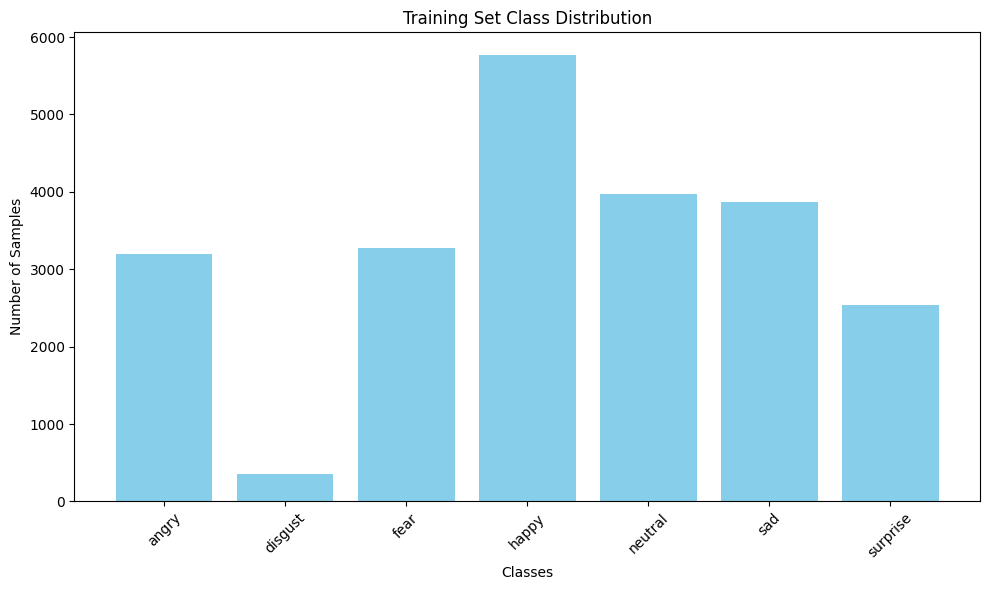

In [4]:
print("Class distribution in train set")
print("Number of classes: ", len(train_generator.class_indices))
print("Classes: ", train_generator.class_indices)

# plotting class distribution in train set

train_classes = train_generator.classes

# Class names
class_labels = list(train_generator.class_indices.keys())

# Count the number of samples per class
train_class_counts = np.bincount(train_classes)


x = np.arange(len(class_labels))  # Position of bars

plt.figure(figsize=(10, 6))
plt.bar(x, train_class_counts, color='skyblue')
plt.title("Training Set Class Distribution")
plt.xticks(x, class_labels, rotation=45)
plt.ylabel("Number of Samples")
plt.xlabel("Classes")
plt.tight_layout()
plt.show()



We can see from the above graph that the data is highly imbalanced, where `angry`,`fear`,`neutral`, `sad`, and `surprised` are fairly balanced. But for `disgust` and `happy`, they are as far as the earth to the sun from being balanced.

In [5]:

for expression in os.listdir(train_path ):
    print(str(len(os.listdir(train_path  + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


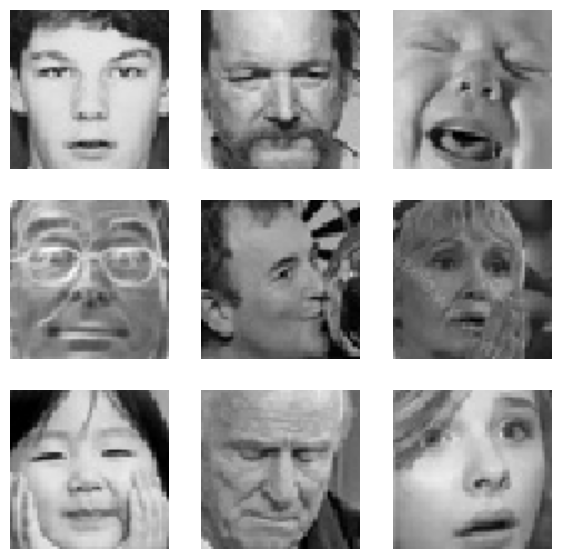

In [6]:
plt.figure(figsize=(7, 7))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_generator[i][0][0])
    plt.axis("off")

The above image are some examples of images in the dataset.

In [7]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


#### Solving imbalancad datasets
So, one of the tachniques that I have used as shown above like giving class weights, can help in imbalanced datasets, but in this case class weights did not make an improvments in the result, same as over sampling and undersampling.

# 2. Model Creation

In this section I will cover the following parts:
1. Model Structure
2. Model Training

In [8]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


> This was the difficult part because WSL was not working form me and I tried to downgrade TensorFlow, Python, NumPy, and CUDA to a version that is supported by Windows OS. 

### 2.1. Model Structure

The model consists of a 2D Convolution layer, followed by 2D Max Pooling, and then a Dropout layer. <br>
This structure is repeated 4 times with increasing number of Convolution filters.<br>
This ends with a global average pooling with a dense, dropout and ending with a final dence layer with 7, with an activation of `softmax`, as the problem is classification.


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),
    
    
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

> I have tried to use transfer learning models including VGG16, InceptionV3, mobileNet and more. it was very hard for me to experment with these models since it takes long time to train and give almost the same result as designing a deep learning architecture from scratch.

### 2.2. Model Training

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
180/180 [==============================] - 18s 78ms/step - loss: 1.8239 - accuracy: 0.2473 - precision: 0.3333 - recall: 4.3539e-05 - val_loss: 1.8134 - val_accuracy: 0.2513 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
180/180 [==============================] - 11s 63ms/step - loss: 1.7883 - accuracy: 0.2578 - precision: 0.4082 - recall: 8.7078e-04 - val_loss: 1.7320 - val_accuracy: 0.2862 - val_precision: 0.4583 - val_recall: 0.0096
Epoch 3/100
180/180 [==============================] - 12s 64ms/step - loss: 1.6870 - accuracy: 0.3078 - precision: 0.6492 - recall: 0.0324 - val_loss: 1.6084 - val_accuracy: 0.3581 - val_precision: 0.7312 - val_recall: 0.0559
Epoch 4/100
180/180 [==============================] - 12s 68ms/step - loss: 1.5441 - accuracy: 0.3975 - precision: 0.6918 - recall: 0.1346 - val_loss: 1.4419 - val_accuracy: 0.4473 - val_precision: 0.7784 - val_recall: 0.1658
Epoch 5/100
180/180 [==============================] - 13s 70ms/step - loss:

# 3. Training Results

In this section I will cover the following parts:
1. Model Accuracy
2. Confusion Matrix

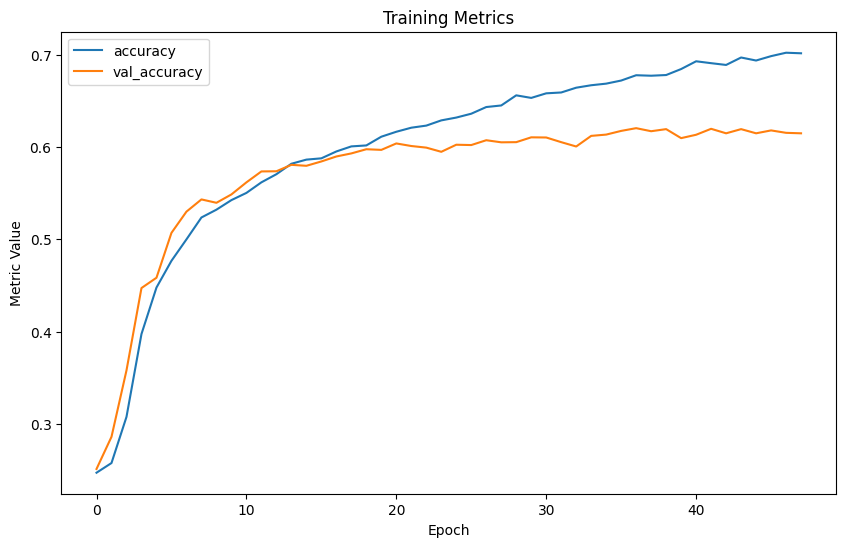

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Training Metrics")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

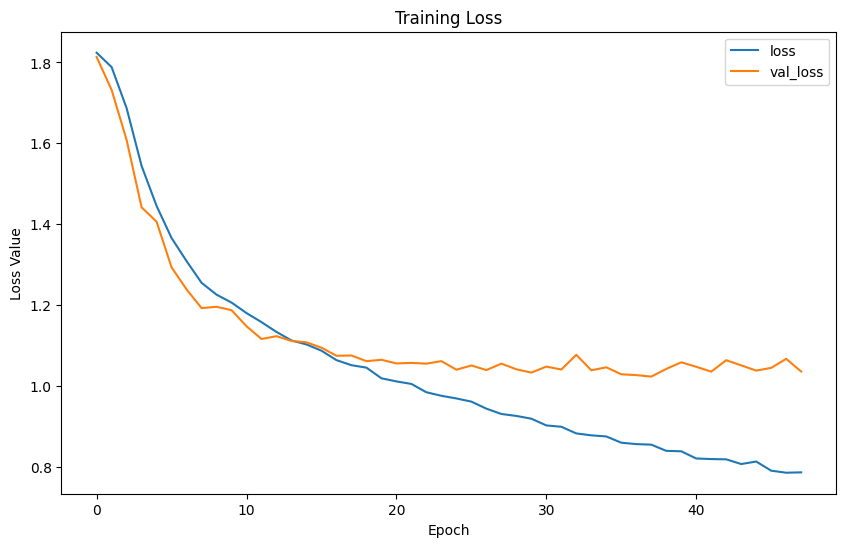

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()
plt.show()


In [12]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)



57/57 [==============================] - 6s 101ms/step - loss: 1.0224 - accuracy: 0.6243 - precision: 0.7566 - recall: 0.4923
Test Loss: 1.0223500728607178
Test Accuracy: 0.6242685914039612
Test Precision: 0.7565831542015076
Test Recall: 0.492337703704834


In [13]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


INFO:tensorflow:Assets written to: ram://82270d77-2d4b-43a5-b602-464063b48c0f/assets


INFO:tensorflow:Assets written to: ram://82270d77-2d4b-43a5-b602-464063b48c0f/assets


57/57 [==============================] - 3s 55ms/step


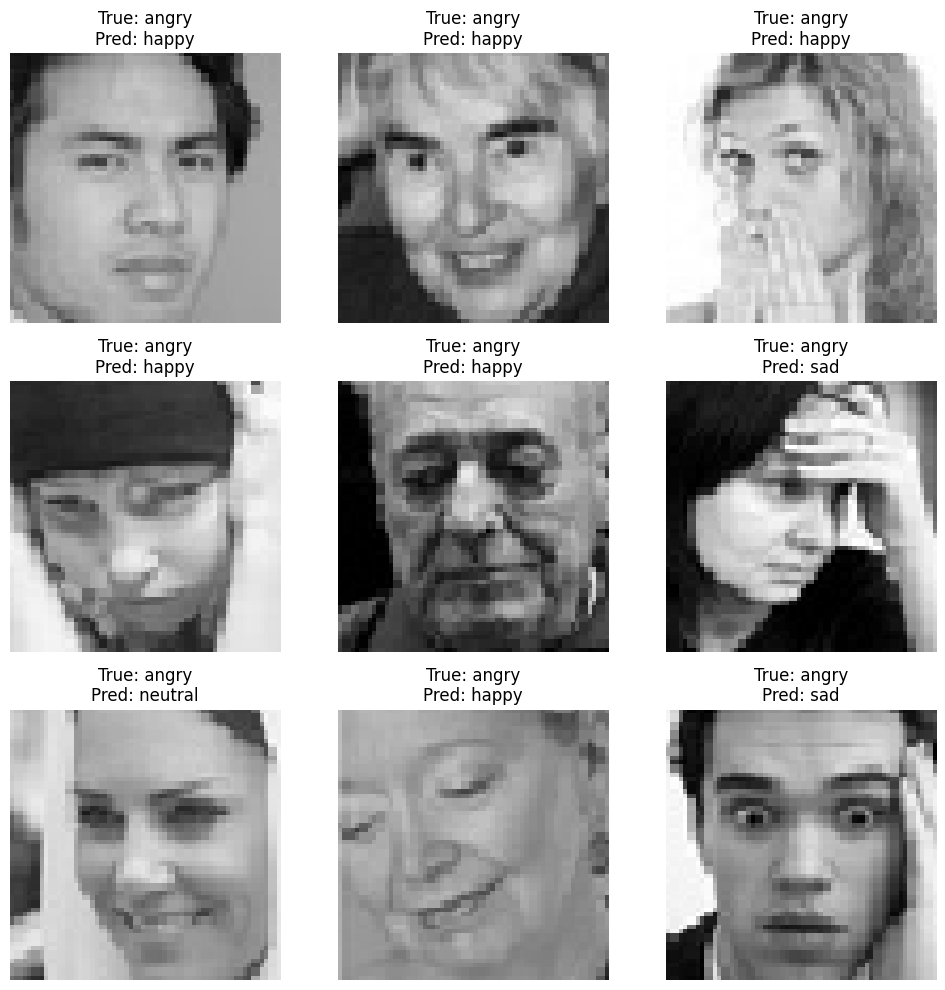

In [16]:
true_labels = test_generator.classes
predicted_probs = model.predict(test_generator)
predicted_labels = np.argmax(predicted_probs, axis=1)

misclassified_indices = np.where(true_labels != predicted_labels)[0]

num_images_to_display = 9 
plt.figure(figsize=(10, 10))
for i in range(min(len(misclassified_indices), num_images_to_display)):
    index = misclassified_indices[i]
    image, true_label = test_generator[index][0][0], true_labels[index]
    predicted_label = predicted_labels[index]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"True: {class_labels[true_label]}\nPred: {class_labels[predicted_label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In my opinion the labiling in the dataset is not very accurate.